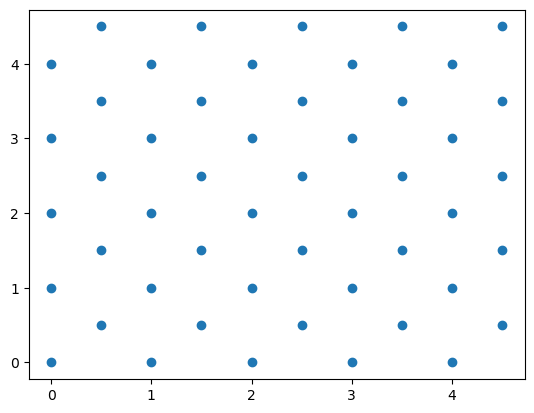

In [32]:
from dynmat import UnitCell, fractional_to_cartesian_transform
import matplotlib.pyplot as plt
import numpy as np

u = UnitCell(
    lattice_lengths = (1, 1, 1),
    lattice_angles = (90, 90, 90),
    atomic_basis = [
        ("Na", 0.0, 0.0, 0.0),
        ("Cl", 0.5, 0.5, 0.0),
    ]
)



u = u.make_supercell((5, 5, 0))

T = fractional_to_cartesian_transform(
    (u.a, u.b, u.c),
    (u.alpha, u.beta, u.gamma)
)
atom_x, atom_y, atom_z = np.array([T @ (x, y, z)   for _, x, y, z in u.atomic_basis]).T

plt.scatter(atom_x, atom_y)


In [3]:
T

array([[5.        , 2.5       , 0.        ],
       [0.        , 4.33012702, 0.        ],
       [0.        , 0.        , 0.        ]])

In [106]:
alpha = np.deg2rad(90)
beta = np.deg2rad(90)
gamma = np.deg2rad(120)
T = fractional_to_cartesian_transform(
    (5, 5, 5),
    (alpha, beta, gamma)
)


T @ (1, 0, 0), T @ (0, 1, 0), T @ (0, 0, 1)

(array([ 5.000000e+00, -2.500000e+00,  3.061617e-16]),
 array([0.00000000e+00, 4.33012702e+00, 5.30287619e-16]),
 array([0., 0., 5.]))

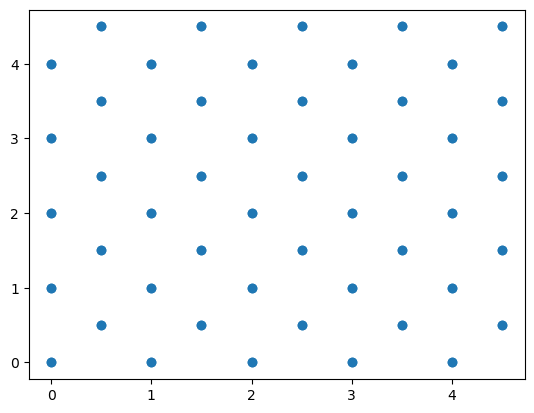

In [95]:
alpha = np.deg2rad(90)
beta = np.deg2rad(60)
gamma = np.deg2rad(90)
T = fractional_to_cartesian_transform(
    (5, 5, 5),
    (alpha, beta, alpha)
).T

atom_x, atom_y, _ = np.array([T @ (x, y, 0)   for _, x, y, _ in u.atomic_basis]).T
plt.scatter(atom_x, atom_y)

Text(0.5, 0.92, 'Unit Cell with Angles 40°, 40°, 40°')

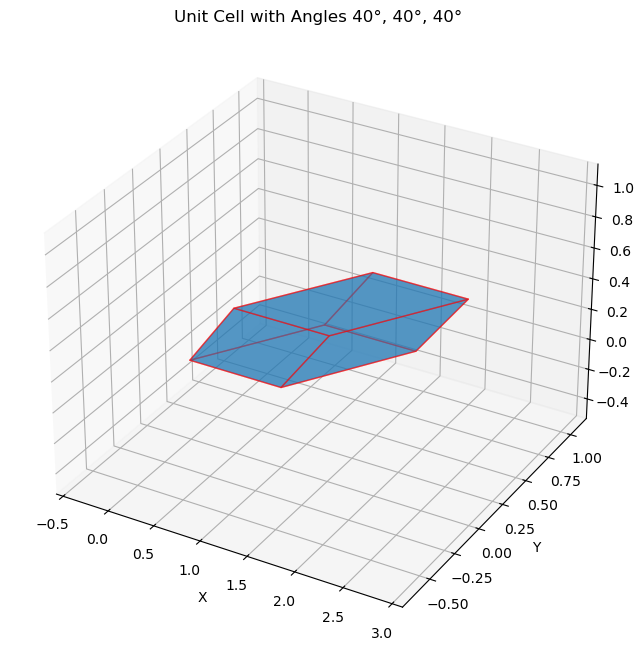

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define parameters for the unit cell at angles 40°, 40°, 40°
a, b, c = 1.0, 1.0, 1.0
lat_a, lat_b, lat_c = 1.0, 1.0, 1.0
alpha, beta, gamma = np.deg2rad(40), np.deg2rad(40), np.deg2rad(40)

# Compute the transformation matrix
def compute_transformation_matrix(a, b, c, alpha, beta, gamma):
    cot_alpha = 1 / np.tan(alpha)
    cot_beta = 1 / np.tan(beta)
    cot_gamma = 1 / np.tan(gamma)

    T = np.array([
        [a, b * np.cos(gamma), c * np.cos(beta)],
        [0, b * np.sin(gamma), c * (cot_alpha - cot_beta * cot_gamma)],
        [0, 0, c * np.sqrt(
            1 - np.cos(beta)**2 - (
                (cot_alpha - cot_beta * cot_gamma)
            )**2
        )]
    ])
    return T

T = compute_transformation_matrix(a, b, c, alpha, beta, gamma)

# Define the corners of the unit cell in fractional coordinates
fractional_coords = np.array([
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
])

# Transform to real coordinates
real_coords = fractional_coords @ T.T

# Define the faces of the unit cell
faces = [
    [0, 1, 4, 2], [0, 2, 6, 3], [0, 1, 5, 3],
    [7, 6, 2, 4], [7, 5, 1, 4], [7, 6, 3, 5]
]

# Visualize the unit cell
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw the faces
for face in faces:
    poly = Poly3DCollection([real_coords[face]], alpha=0.5, edgecolor='r')
    ax.add_collection3d(poly)

# Set labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([real_coords[:, 0].min() - 0.5, real_coords[:, 0].max() + 0.5])
ax.set_ylim([real_coords[:, 1].min() - 0.5, real_coords[:, 1].max() + 0.5])
ax.set_zlim([real_coords[:, 2].min() - 0.5, real_coords[:, 2].max() + 0.5])
ax.set_title("Unit Cell with Angles 40°, 40°, 40°")


In [6]:
cot = lambda x: 1/np.tan(x)
csc = lambda x: 1/np.sin(x)
transformation = np.array([
    [lat_a, lat_b * np.cos(gamma), lat_c * np.cos(beta)],
    [0, lat_b * np.sin(gamma), lat_c * np.sin(beta) * csc(alpha)],
    [0, 0, lat_c * np.sin(beta) * cot(alpha)]
])


transformation

array([[1.        , 0.76604444, 0.76604444],
       [0.        , 0.64278761, 1.        ],
       [0.        , 0.        , 0.76604444]])

In [7]:
T

array([[ 1.        ,  0.76604444,  0.76604444],
       [ 0.        ,  0.64278761, -0.22852303],
       [ 0.        ,  0.        ,  0.60079375]])